**Linear regression  by pixel on camera sensor temperature gain and offset with black body temp as an additional feature.**

In [22]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [23]:
dataset_location = '../dataset/' # put the root or relative path to your dataset here

In [24]:
scene_df = pd.read_hdf(dataset_location + 'scene.hdf5')
calibration_df = pd.read_hdf(dataset_location + 'calibration_set_2.hdf5')

In [27]:
# Function to estimate offset and responsivity
def estimate_parameters(calibration_images, calibration_temperatures):
    height, width = calibration_images[0].shape
    num_pixels = height * width
    
    # Reshape images for linear regression
    images_reshaped = np.array([img.ravel() for img in calibration_images])
    
    offsets = np.zeros(num_pixels)
    responsivities = np.zeros((num_pixels, calibration_temperatures.shape[1]))  # Adjust for multiple features
    
    for i in range(num_pixels):
        model = LinearRegression().fit(calibration_temperatures, images_reshaped[:, i])
        offsets[i] = model.intercept_
        responsivities[i, :] = model.coef_
    
    # Reshape back to original image shape
    offsets = offsets.reshape(height, width)
    responsivities = responsivities.reshape(height, width, -1)  # Adjust for multiple features
    
    return offsets, responsivities

In [28]:
# Ensure all images are correctly typed
scene_df['image'] = scene_df['image'].apply(lambda img: img.astype(np.float32))
calibration_df['image'] = calibration_df['image'].apply(lambda img: img.astype(np.float32))

# Process each scene image
calibration_images = calibration_df['image'].values
calibration_temperatures = np.vstack((calibration_df['t_fpa'].values, calibration_df['t_cn'].values)).T

offsets, gains = estimate_parameters(calibration_images, calibration_temperatures)

In [30]:
# Function to apply the correction to each scene image
def apply_correction(scene_image, offsets, responsivities, scene_temp, avg_black_body_temp):
    height, width = scene_image.shape
    corrected_image = np.zeros_like(scene_image)
    
    for i in range(height):
        for j in range(width):
            intercept = offsets[i, j]
            coef_fpa = responsivities[i, j, 0]
            coef_cn = responsivities[i, j, 1]
            expected_value = intercept + coef_fpa * scene_temp + coef_cn * avg_black_body_temp
            corrected_image[i, j] = scene_image[i, j] - expected_value
    
    return corrected_image

# Calculate the average black body temperature from calibration data
avg_black_body_temp = calibration_df['t_cn'].mean()

# Process each scene image
corrected_scene_images = []
for index, row in scene_df.iterrows():
    scene_image = row['image']
    scene_temp = row['t_fpa']
    corrected_image = apply_correction(scene_image, offsets, gains, scene_temp, avg_black_body_temp)
    corrected_scene_images.append(corrected_image)

# Convert corrected_scene_images to numpy array
corrected_scene_images = np.array(corrected_scene_images)

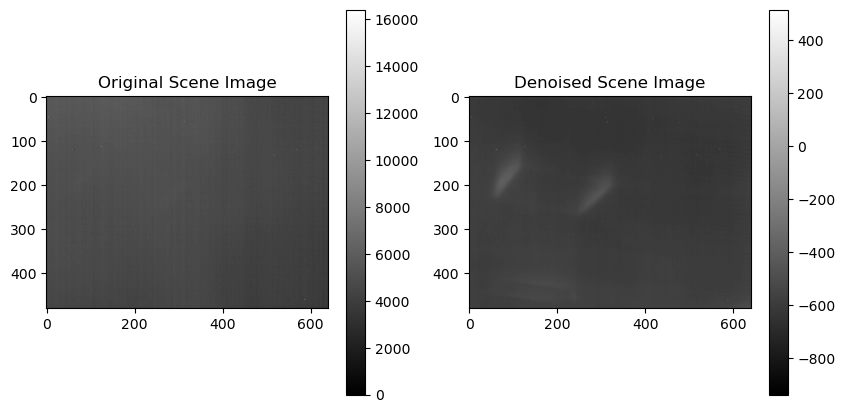

In [31]:
index = 15  # Index of the image to display

plt.figure(figsize=(10, 5))

# Original scene image
plt.subplot(1, 2, 1)
plt.title("Original Scene Image")
plt.imshow(scene_df['image'][index], cmap='gray')
plt.colorbar()

# Denoised scene image
plt.subplot(1, 2, 2)
plt.title("Denoised Scene Image")
plt.imshow(corrected_scene_images[index], cmap='gray')
plt.colorbar()

plt.show()

In [32]:
def save_video_from_images(images, output_filename, fps=60):
    """
    Save a sequence of images as a video.

    Parameters:
    images (list or array): List or array of images (each image should be a 2D or 3D NumPy array).
    output_filename (str): Output video filename (e.g., 'output.avi').
    fps (int): Frames per second for the video.
    """
    # Get the dimensions of the images
    height, width = images[0].shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    for img in images:
        # Ensure image is in the correct format (uint8)
        img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        # If the image is grayscale, convert it to BGR
        if len(img_uint8.shape) == 2:
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        out.write(img_uint8)

    # Release everything when the job is finished
    out.release()

output_filename = 'output-pixel-lr-cn.avi'
save_video_from_images(corrected_scene_images, output_filename)